# Detecting the seasonality of the trees

In this tutorial, we use the bivariate linear regression based PSM in `cfr` to detect the seasonality of the trees (using the TRW data) in PAGES2k.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

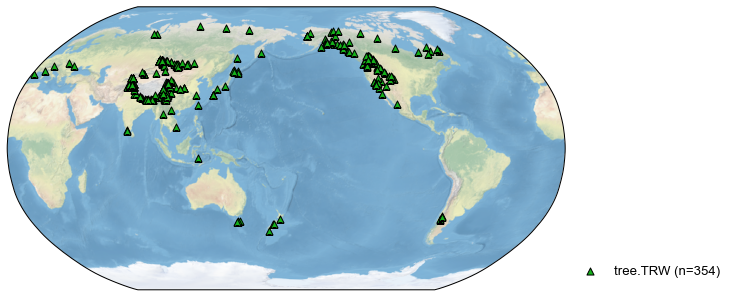

In [2]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)
pdb_TRW = pdb.filter(by='ptype', keys=['TRW'])
fig, ax = pdb_TRW.plot()

### Instrumental observations

In [3]:
dirpath = './data/CRUTS'

obs_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp', load=True)
obs_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre', load=True)

In [4]:
obs_pr = obs_pr.rename('pr')
obs_tas = obs_tas.rename('tas')

In [5]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 1.74 s, sys: 341 ms, total: 2.08 s
Wall time: 2.1 s


In [6]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [7]:
obs_pr_new = obs_pr.wrap_lon()

In [8]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for `ProxyDatabase`

In [9]:
%%time

pdb_TRW.del_clim()
pdb_TRW.get_clim(obs_tas_new, tag='obs')
pdb_TRW.get_clim(obs_pr_new, tag='obs')

Getting the nearest climate for ProxyRecord: 100%|██████████| 354/354 [00:15<00:00, 22.66it/s]

CPU times: user 26.9 s, sys: 1.27 s, total: 28.2 s
Wall time: 28.2 s


In [10]:
pdb_TRW.records['NAm_153'].clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([-12.       , -11.7      ,  -5.8      , ...,  -1.2      ,
        -7.2000003,  -7.8      ], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 52.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

In [11]:
pd.to_pickle(pdb_TRW, './data/pdb_TRW_clim.pkl')

## Create a PSM object

In [12]:
pdb_TRW = pd.read_pickle('./data/pdb_TRW_clim.pkl')

In [13]:
%%time

sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]

mdl = {}
for pid, pobj in tqdm(pdb_TRW.records.items(), total=pdb_TRW.nrec):
    mdl[pid] = cfr.psm.Bilinear(pobj)
    mdl[pid].calibrate(season_list1=sn_list, season_list2=sn_list)

100%|██████████| 354/354 [06:25<00:00,  1.09s/it]

CPU times: user 6min 16s, sys: 8.9 s, total: 6min 25s
Wall time: 6min 25s


In [18]:
pd.to_pickle(mdl, './data/TRW_bilinear_PSMs.pkl')

In [19]:
mdl = pd.read_pickle('./data/TRW_bilinear_PSMs.pkl')

In [20]:
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]

lats = []
lons = []
sn_tas_idx = []
sn_pr_idx = []
ns_tas = np.zeros(len(sn_list), dtype=int)
ns_pr = np.zeros(len(sn_list), dtype=int)
for pid, pobj in pdb_TRW.records.items():
    sn_tas, sn_pr = mdl[pid].calib_details['seasonality']
    idx_tas = sn_list.index(sn_tas)
    sn_tas_idx.append(idx_tas)
    ns_tas[idx_tas] += 1
    idx_pr = sn_list.index(sn_pr)
    sn_pr_idx.append(idx_pr)
    ns_pr[idx_pr] += 1
    lats.append(pobj.lat)
    lons.append(pobj.lon)


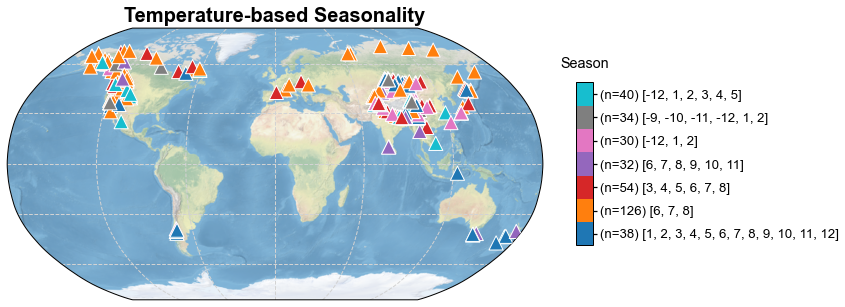

Figure saved at: "figs/sn_tas.pdf"


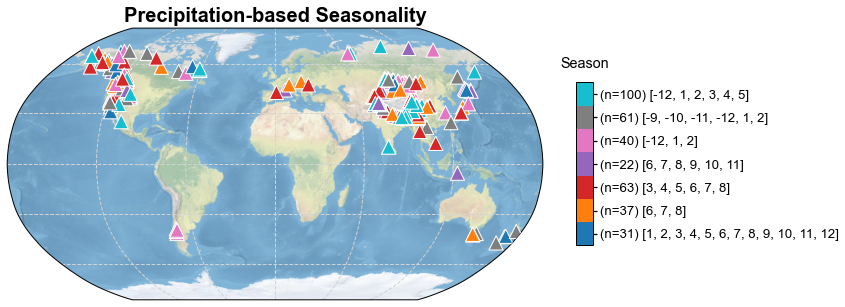

Figure saved at: "figs/sn_pr.pdf"


In [21]:
cmap = 'tab10'
cmap_over = 'tab:purple'
levels = np.arange(0, len(sn_list)+1)
cbar_ticks = np.arange(0, len(sn_list))+0.5
cbar_labels_tas = [f'(n={ns_tas[i]}) {sn_list[i]}' for i in range(len(sn_list))]
cbar_labels_pr = [f'(n={ns_pr[i]}) {sn_list[i]}' for i in range(len(sn_list))]
cbar_title = 'Season'

fig, ax = cfr.visual.plot_scatter_map(
    sn_tas_idx, lats, lons, marker='^', title='Temperature-based Seasonality',
    cmap=cmap, cmap_over=cmap_over, cbar_title=cbar_title,
    levels=levels, cbar_ticks=cbar_ticks, cbar_labels=cbar_labels_tas)
cfr.showfig(fig)
cfr.savefig(fig, './figs/sn_tas.pdf')

fig, ax = cfr.visual.plot_scatter_map(
    sn_pr_idx, lats, lons, marker='^', title='Precipitation-based Seasonality',
    cmap=cmap, cmap_over=cmap_over, cbar_title=cbar_title,
    levels=levels, cbar_ticks=cbar_ticks, cbar_labels=cbar_labels_pr)
cfr.showfig(fig)
cfr.savefig(fig, './figs/sn_pr.pdf')